In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on 2023-05-12

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"

synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
retrieval_src_path=my_git_path+"/hamp_retrieval_haloac3/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,synth_ar_path+"src/")
sys.path.insert(4,synth_ar_path+"plotting/")
sys.path.insert(5,hamp_processing_path)
sys.path.insert(6,hamp_processing_path+"plotting/")
sys.path.insert(7,retrieval_src_path+"src/")
sys.path.insert(8,start_path+"/../plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA 
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
import Performance
performance=Performance.performance()

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Plotting routines

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams.update({"font.size":16})

def plot_component_tendency(d_IWV_dt,d_IWV_dt_uncertainty,
                            adv_q_series,mass_div_series,
                            adv_q_unc,mass_div_unc,
                            #adv_q_series_min,adv_q_series_max,
                            #mass_div_series_min,mass_div_series_max,
                            sector_precip,Evap_Sectors,
                            plot_path=os.getcwd()+"/../plots/",with_residuals=True,
                            scalar_based_div=False):

    budget_components_fig, (ax1, ax2) =plt.subplots(2,1,figsize=(12,9),gridspec_kw={'height_ratios': [0.5, 1]})
    sns.boxplot(data=merged_halo_icon_ivt, x="Sector", y="IVT",ax=ax1,palette=["darkgreen","seagreen","teal","lightseagreen"],
               width=0.4)
    ax1.set_xlabel(" ")
    ax1.set_ylabel("IVT ($\mathrm{kg\,m}^{-1}{\mathrm{s}}^{-1})$")
    # Local change IWV
    ax2.errorbar([0.8,1.8,2.8,3.8],d_IWV_dt_hamp.values,yerr=d_IWV_dt_uncertainty, marker='v', mfc='grey',
             mec='black', ecolor="lightgrey",ms=20, mew=1,ls="",label="IWV tendency")
    # Evaporation
    ax2.errorbar([0.9,1.9,2.9,3.9], -1*Evap_Sectors["mean"].values, yerr=Evap_Sectors["std"].values, marker='s', mfc='red',
             mec='black', ecolor="lightgrey",ms=10, mew=1,ls="",label="Evap")
    # Precipitation
    ax2.errorbar([0.95,1.95,2.95,3.95],-1*sector_precip["rate"].values,
                 yerr=[(sector_precip["max_rate"]-sector_precip["rate"].values),
                       (sector_precip["rate"].values-sector_precip["min_rate"].values)],marker="s",
                 # ---> think about direction and sign of errorbars
                 ecolor="lightgrey",mfc="lightblue",
                mec="black",ms=10,mew=1,ls="",label="-Precip")
    # Mass divergence
    ax2.errorbar(np.array([1,2,3,4]),-mass_div_series,yerr=mass_div_unc,
                 #yerr=[mass_div_series_max-mass_div_series,mass_div_series-mass_div_series_min],
                 marker="s",mfc="teal",ls="",ms=10,mew=1,markeredgecolor="k",ecolor="lightgrey",label="mass conv")
    
    # Moisture Advection
    ax2.errorbar(np.array([1.05,2.05,3.05,4.05]),-adv_q_series,yerr=adv_q_unc,
                 #yerr=[adv_q_series_max-adv_q_series,adv_q_series-adv_q_series_min],
                 marker="s",ms=10,mew=1,
                 mfc="darkgreen",ls="",markeredgecolor="k",ecolor="lightgrey",label="q Adv")
    #Residuals
    if with_residuals:
        ax2.errorbar(np.array([1.1,2.1,3.1,4.1]),residual_e,yerr=residual_e_unc,marker="x",
                     mfc="k",mec="k",ecolor="lightgrey",ms=10,mew=1,ls="",label="residual")
        
    ##
    ax2.axhline(y=0,ls="--",lw=1,color="k")
    ax2.set_ylabel("Moisture Budget \nContribution ($\mathrm{mm\,h}^{-1}$)")
    ax2.set_xticks([1,2,3,4])
    ax2.set_xticklabels(["S1","S2","S3","S4"])#
    ax1.spines['left'].set_linewidth(2)
    ax2.spines['left'].set_linewidth(2)

    ax1.spines['bottom'].set_linewidth(2)
    ax2.spines['bottom'].set_linewidth(2)
    ax1.xaxis.set_tick_params(width=2,length=4)
    ax1.yaxis.set_tick_params(width=2,length=4)
    ax2.xaxis.set_tick_params(width=2,length=4)
    ax2.yaxis.set_tick_params(width=2,length=4)
    col_number=5
    if with_residuals:
        col_number+=1
    legend=ax2.legend(loc="lower right",ncol=col_number,frameon=True,fontsize=12)
    frame = legend.get_frame()
    frame.set_color('lightgrey')
    frame.set_edgecolor('black')

    import matplotlib.patches as mpatches
    sns.despine(offset=10)
    file_end=".png"
    fig_name="HALO_Budget_components_tendency"
    if with_residuals:
        fig_name+="_with_residuals"
    if scalar_based_div:
        fig_name+="_scalar_based"
    fig_name+=file_end
    budget_components_fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)

In [4]:
sectors=["S1","S2","S3","S4"]
Evap_Sectors=pd.DataFrame(data=np.nan,columns=["mean","std"],index=sectors)
Evap_Sectors["mean"]=[0.002438,0.00275,-0.015,-0.0038]
Evap_Sectors["std"]=[0.006509,0.005,0.0083,0.0101]

scalar_based_div=False
warm_sonde_values={}

# scalar-based divergence values
if scalar_based_div:
    warm_sonde_values["S1"]={
      'mass_div': -0.41276886889204784,
      'mass_div_min': -0.7301260286358718,
      'mass_div_max': -0.09541170914822367,
      'q_ADV': -0.7907497132061316,
      'q_ADV_min': -1.565287488594897,
      'q_ADV_max': -0.016211937817365973}

    warm_sonde_values["S2"]={
        'mass_div': -0.1882352622233449,
        'mass_div_min': -0.6452538732851526,
        'mass_div_max': 0.2687833488384628,
        'q_ADV': -0.5474630545351018,
        'q_ADV_min': -1.3557554102823333,
        'q_ADV_max': 0.2608293012121298}

    warm_sonde_values["S3"]={
         'mass_div': -0.22776075016667244,
         'mass_div_min': -0.5096074494526325,
         'mass_div_max': 0.05408594911928759,
         'q_ADV': -0.7544264531963553,
         'q_ADV_min': -1.3814041637839345,
         'q_ADV_max': -0.12744874260877628}
    #    'mass_div': -0.23570411496183644,
    #    'mass_div_min': -0.602622062208785,
    #    'mass_div_max': 0.13121383228511205,
    #    'q_ADV': -0.7594541149453358,
    #    'q_ADV_min': -1.497718568202485,
    #    'q_ADV_max': -0.021189661688186773}

    warm_sonde_values["S4"]={
        'mass_div': -0.41276886889204784,
        'mass_div_min': 0.056,
        'mass_div_max': -0.09541170914822367,
        'q_ADV': -0.7907497132061316,
        'q_ADV_min': -1.565287488594897,
        'q_ADV_max': -0.016211937817365973}
else:
    # List of uncertainties
    #---------------------------------
    #S1
    # UNC adv  0.09904659648151819
    # UNC mass 0.0390540623580486
    #---------------------------------
    #S2
    # UNC adv  0.12255051592378231
    # UNC mass 0.05330051908475317
    #---------------------------------
    #---------------------------------
    #S4
    warm_sonde_values["S1"]={
      'mass_div': 0.320,
      'mass_div_min': 0.056,
      'mass_div_max': 0.323,
      'mass_div_unc':0.05606615583661565,#0.0390540623580486,
        'q_ADV': 0.162,
      'q_ADV_min': -0.42,
      'q_ADV_max': 0.74,
      'q_ADV_unc':0.13915442129379024 #now 400 meter correlation length 0.09904659648151819,
        }

    warm_sonde_values["S2"]={
        'mass_div': 0.369,
        'mass_div_min': -0.006,
        'mass_div_max': 0.378,
        'mass_div_unc': 0.07579105179504261,#0.0533,
        'q_ADV': 0.309,
        'q_ADV_min': -0.328,
        'q_ADV_max': 0.946,
        'q_ADV_unc': 0.1722415822353062,#0.12255051592378231
        }
    warm_sonde_values["S3"]={
         'mass_div': -0.01606136995913354,
         'mass_div_min': -0.07745809018313218,
         'mass_div_max': 0.14004981735327982,
         'mass_div_unc': 0.09455006318149353,#0.06758506711408048,
         'q_ADV': -0.4327365190866554,
         'q_ADV_min': -1.0441686154792087,
         'q_ADV_max': 0.1786,
         'q_ADV_unc': 0.14011083522506143#0.1029587189598431
    }
    #UNC adv 0.2973193759560851
    #UNC mass 0.08439010200621463
    
    warm_sonde_values["S4"]={
        'mass_div': -0.034578940690504,
        'mass_div_min': -0.1419551986643343,
        'mass_div_max': 0.1648389618742725,
        'mass_div_unc': 0.10572761034063809,#0.08439010200621463,
        'q_ADV': -0.1992739541087698,
        'q_ADV_min': -1.3204634891704425,
        'q_ADV_max': 0.9219155809529028,
        'q_ADV_unc':0.38034635428879077#0.2973193759560851,
    }
# old values may 2023
#d_IWV_dt_sonde=pd.Series(data=[-0.25,-0.34,0.05,np.nan],index=["S1","S2","S3","S4"]) 
#d_IWV_dt_hamp=pd.Series(data=[-0.49,-0.31,0.66,np.nan],index=["S1","S2","S3","S4"]) 
d_IWV_dt_sonde=pd.Series(data=[-0.25,-0.34,0.05,np.nan],index=["S1","S2","S3","S4"]) 
d_IWV_dt_hamp=pd.Series(data=[-0.72,-0.19,0.66,0.56],index=["S1","S2","S3","S4"]) 
d_IWV_dt_uncertainty=pd.Series(data=[0.21,0.23872126958677942,0.30,0.1],index=["S1","S2","S3","S4"])

# third hamp value shifted due to not working F-BAND module
flights=["RF05","RF06"]
ars_of_day=["AR_entire_1","AR_entire_2"]

In [5]:
campaign="HALO_AC3"
halo_icon_hmps={}
halo_icon_ivts={}
precip_rates={}
flight_dates={"RF05":"20220315",
              "RF06":"20220316"}
s=0

for flight in flights:
    for ar_of_day in ars_of_day:
        sector_to_plot="warm"
        from simplified_flight_leg_handling import simplified_run_grid_main
        with HiddenPrints():
            halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
            simplified_run_grid_main(flight=[flight],config_file_path=major_work_path,ar_of_day=ar_of_day)
        # ICON File
        icon_major_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
        hydrometeor_icon_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
        icon_resolution=2000 # units m
        upsample_time="20min"
        date=flight_dates[flight]
        interp_icon_hmp_file=flight+"_"+ar_of_day+"_"+"interpolated_HMP.csv"
        interp_icon_ivt_file=flight+"_"+ar_of_day+"_"+"ICON_Interpolated_IVT.csv"
        icon_var_list=ICON.lookup_ICON_AR_period_data(cmpgn_cls.name,[flight],ar_of_day,
                                                 icon_resolution,
                                                 hydrometeor_icon_path,
                                                 synthetic=False)

        ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(
        cmpgn_cls,icon_var_list,halo_df,[flight],date,
        interpolated_hmp_file=interp_icon_hmp_file,
        interpolated_hmc_file=None,ar_of_day=ar_of_day,
        upsample_time=upsample_time,
        synthetic_icon=False,
        synthetic_flight=False)

        hydrometeor_icon_path=hydrometeor_icon_path+flight+"/"
        ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)
        halo_icon_ivts[flight+"_"+ar_of_day]=pd.read_csv(hydrometeor_icon_path+interp_icon_ivt_file,index_col=0)
        halo_icon_ivts[flight+"_"+ar_of_day]["Sector"]=sectors[s]
        halo_icon_hmps[flight+"_"+ar_of_day]=ICON_on_HALO.load_interpolated_hmp()
        halo_icon_hmps[flight+"_"+ar_of_day]["Sector"]=sectors[s]
        # read precip rates########
        rate_path =cmpgn_cls.campaign_path+"/data/precip_rates/"
        rate_fname=sector_to_plot+"_precip_"+flight+"_"+ar_of_day+".csv"
        precip_rates[flight+"_"+ar_of_day]=pd.read_csv(rate_path+rate_fname,index_col=0)
        precip_rates[flight+"_"+ar_of_day]["Sector"]=s+1
        if s==0:
            merged_precipitation=precip_rates[flight+"_"+ar_of_day]
        else:
            merged_precipitation=pd.concat([merged_precipitation,precip_rates[flight+"_"+ar_of_day]])
        
        ############
        s+=1
merged_rates         = pd.concat(precip_rates.values())
merged_halo_icon_hmp = pd.concat(halo_icon_hmps.values())
merged_halo_icon_ivt = pd.concat(halo_icon_ivts.values())
        

RF05_AR_entire_1_interpolated_HMP.csv  is already calculated and will be opened
RF05_AR_entire_2_interpolated_HMP.csv  is already calculated and will be opened
RF06_AR_entire_1_interpolated_HMP.csv  is already calculated and will be opened
RF06_AR_entire_2_interpolated_HMP.csv  is already calculated and will be opened


In [6]:
#halo_era5["Interp_Precip"].mean()

In [7]:
merged_rates.index=pd.DatetimeIndex(merged_rates.index)
merged_rates=merged_rates.resample("10s").mean()

In [8]:
merged_precipitation["min_rain"]=merged_precipitation[["r_norris","r_palmer","r_chandra"]].min(axis=1)
merged_precipitation["max_rain"]=merged_precipitation[["r_norris","r_palmer","r_chandra"]].max(axis=1)
merged_precipitation["min_snow"]=merged_precipitation[["s_schoger","s_matrosov","s_heymsfield"]].min(axis=1)
merged_precipitation["max_snow"]=merged_precipitation[["s_schoger","s_matrosov","s_heymsfield"]].max(axis=1)
merged_precipitation["min_rate"]=merged_precipitation["min_rain"]+merged_precipitation["min_snow"]
merged_precipitation["max_rate"]=merged_precipitation["max_rain"]+merged_precipitation["max_snow"]

In [9]:
sector_precip=merged_precipitation.groupby("Sector").mean()
sector_precip.index=sectors
sector_precip["rate"]

S1    0.032262
S2    0.012351
S3    0.030188
S4    0.001876
Name: rate, dtype: float64

In [10]:
sum_sector_precip=merged_precipitation.groupby("Sector").sum()
sum_sector_precip["rate"]

Sector
1    127.016524
2     56.135946
3    112.237914
4      3.680899
Name: rate, dtype: float64

In [11]:
adv_q_series        = pd.Series(data=[warm_sonde_values[sector]['q_ADV'] for sector in sectors],
                             index=sectors)
adv_q_series_min    = pd.Series(data=[warm_sonde_values[sector]['q_ADV_min'] for sector in sectors],
                             index=sectors)
adv_q_series_max    = pd.Series(data=[warm_sonde_values[sector]['q_ADV_max'] for sector in sectors],
                             index=sectors)
adv_q_unc           = pd.Series(data=[warm_sonde_values[sector]['q_ADV_unc'] for sector in sectors])
mass_div_series     = pd.Series(data=[warm_sonde_values[sector]['mass_div'] for sector in sectors],
                             index=sectors)
mass_div_series_min = pd.Series(data=[warm_sonde_values[sector]['mass_div_min'] for sector in sectors],
                             index=sectors)
mass_div_series_max = pd.Series(data=[warm_sonde_values[sector]['mass_div_max'] for sector in sectors],
                             index=sectors)
mass_div_unc        = pd.Series(data=[warm_sonde_values[sector]['mass_div_unc'] for sector in sectors])
mass_div_unc

0    0.056066
1    0.075791
2    0.094550
3    0.105728
dtype: float64

## Residual

In [12]:
#d_IWV/dt=-nabla IVT + E - P + €
# ->
#€=d_IWV/dt+nabla IVT -E +P
residual_e=d_IWV_dt_hamp+adv_q_series.values+mass_div_series.values-Evap_Sectors["mean"]+sector_precip["rate"].values
residual_e_unc=np.sqrt(d_IWV_dt_uncertainty**2+\
                       mass_div_unc.values**2+\
                       adv_q_unc.values**2+\
                       #((mass_div_series_max-mass_div_series_min)/2)**2+\
                       #((adv_q_series_max-adv_q_series_min)/2)**2+\
                       ((sector_precip["max_rate"]-sector_precip["min_rate"])/2)**2+\
                       Evap_Sectors["std"]**2)
residual_e_unc

S1    0.259792
S2    0.304172
S3    0.345512
S4    0.407366
dtype: float64

Figure saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/HALO_Budget_components_tendency_with_residuals.png


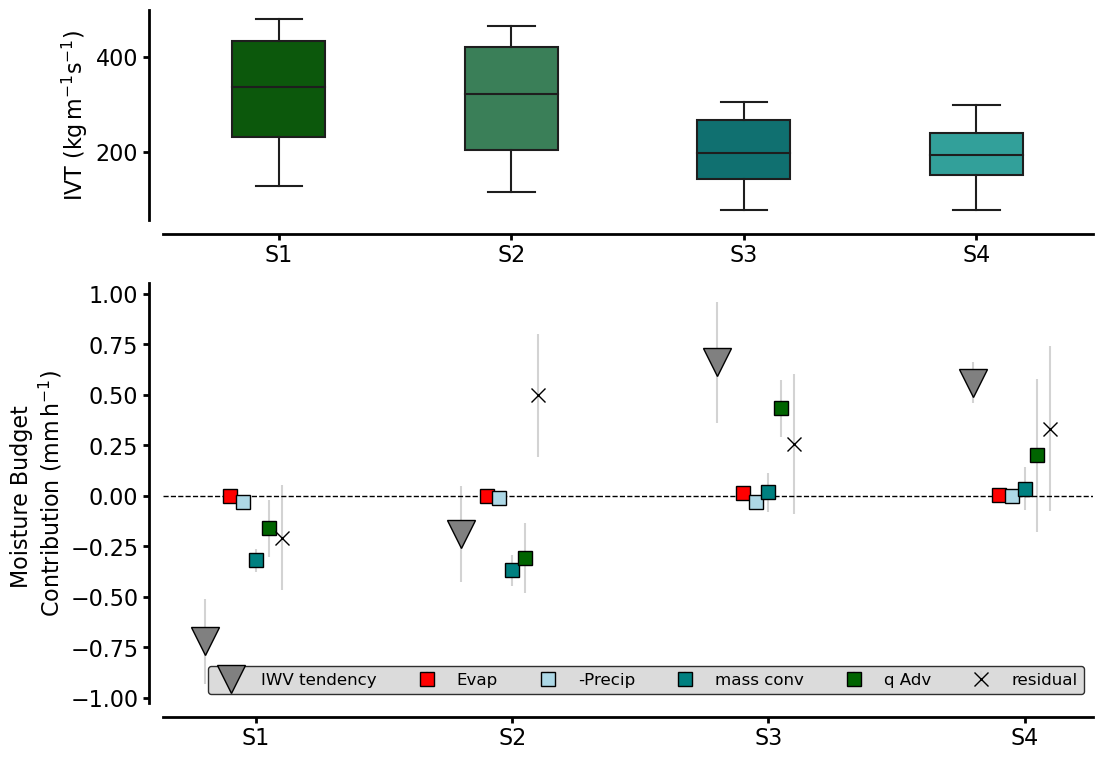

In [15]:
plot_component_tendency(d_IWV_dt_hamp,d_IWV_dt_uncertainty,
                            adv_q_series,mass_div_series,adv_q_unc,mass_div_unc,
                            sector_precip,Evap_Sectors)

In [ ]:
# Old stuff to be deleted
#------------------------------------------------------------------------------------------------------------------------------#
#Q ADV
#ax2.errorbar(np.array([1,2,3,4])-0.15,
#             -1*np.array([-0.7907497132061316,-0.5474630545351018,-0.7594541149453358,-0.41276886889204784]),
#            yerr=[(-0.7301260286358718--0.09541170914822367)/2,
#                  (-0.6452538732851526--0.2687833488384628)/2,
#                  (-0.602622062208785-0.13121383228511205)/2,
#                  (-0.7301260286358718-0.09541170914822367)/2],
#            marker="^",ms=15,markeredgecolor="k",mfc="teal",elinewidth=2,ecolor="teal",ls="",label="Q ADV")
#IWV tendency
#ax2.scatter(np.array([1,2,3])+0.1,np.array([-0.25,-0.34,0.05]),
#            marker="o",s=200,edgecolor="k",facecolor="grey",label="IWV tendency \n(Dropsondes)")
#ax2.scatter(np.array([1,2,3])+0.1,np.array([-0.49,-0.31,0.66]),
#            marker="o",s=75,edgecolor="k",facecolor="lightgrey",label="IWV tendency \n(HAMP)")
